In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the CSV file
file_path = r"C:\Users\Vasan\Downloads\semiconductors_esg_consolidated 1.csv"
df = pd.read_csv(file_path)

# Show first few rows to understand structure
df.head()


,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,nb_points_of_observations,pillar,Industry,year,metric_value_scaled,metric_value_log
0,StarPower Semiconductor Ltd,5066575432,int,CALCULATED,Has the company set targets or objectives to b...,TARGETS_EMISSIONS,Yes/No,0.0,163,E_opportunity,Semiconductors,2020,0.0,0.0
1,StarPower Semiconductor Ltd,5066575432,int,CALCULATED,Has the company set targets or objectives to b...,TARGETS_EMISSIONS,Yes/No,0.0,163,E_opportunity,Semiconductors,2022,0.0,0.0
2,StarPower Semiconductor Ltd,5066575432,int,CALCULATED,Has the company set targets or objectives to b...,TARGETS_WATER_EFFICIENCY,Yes/No,0.0,163,E_opportunity,Semiconductors,2019,0.0,0.0
3,StarPower Semiconductor Ltd,5066575432,int,REPORTED,Does the company report on initiatives to recy...,WASTE_REDUCTION_TOTAL,Yes/No,0.0,163,E_opportunity,Semiconductors,2023,0.0,0.0
4,StarPower Semiconductor Ltd,5066575432,int,CALCULATED,Does the company have a policy to improve its ...,POLICY_SUSTAINABLE_PACKAGING,Yes/No,0.0,163,E_opportunity,Semiconductors,2019,0.0,0.0


In [ ]:
# Step 1: Filter only quantitative metrics with numeric values
quant_df = df[df['data_type_class'] == 'quantitative']

# Step 2: Pivot to get companies as rows and metrics as columns
pivot_df = quant_df.pivot_table(index='company_name', 
                                 columns='metric_name', 
                                 values='metric_value', 
                                 aggfunc='mean')

# Drop rows with missing values for PCA
pivot_df_clean = pivot_df.dropna()

# Step 3: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df_clean)

# Step 4: Apply PCA
pca = PCA(n_components=2)  # reduce to 2 components for visualization
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA result
pca_df = pd.DataFrame(data=pca_components, 
                      columns=['PC1', 'PC2'],
                      index=pivot_df_clean.index)

# Since `ace_tools` is unavailable in this environment, we'll just return the DataFrame directly
pca_df.reset_index(inplace=True)
pca_df.head()

KeyError: 'data_type_class'

In [ ]:
# Step 6: Compute PCA loadings (contributions of original metrics to PCs)

# Get the column names (original ESG metrics)
feature_names = pivot_df_clean.columns

# Create a DataFrame for the PCA loadings
loadings_df = pd.DataFrame(pca.components_.T,
                           columns=['PC1', 'PC2'],
                           index=feature_names)

# Sort by absolute value to show most influential features
loadings_df['PC1_abs'] = loadings_df['PC1'].abs()
loadings_df['PC2_abs'] = loadings_df['PC2'].abs()

# Show top 10 contributing features for each component
top_pc1 = loadings_df.sort_values(by='PC1_abs', ascending=False)[['PC1']].head(10)
top_pc2 = loadings_df.sort_values(by='PC2_abs', ascending=False)[['PC2']].head(10)

top_pc1, top_pc2


(                        PC1
 metric_name                
 Waste_Management   0.615393
 GHG_Emissions      0.594297
 Energy_Management -0.403161
 Water_Management  -0.324906,
                         PC2
 metric_name                
 Water_Management   0.744486
 Energy_Management -0.658508
 GHG_Emissions     -0.095787
 Waste_Management   0.054160)

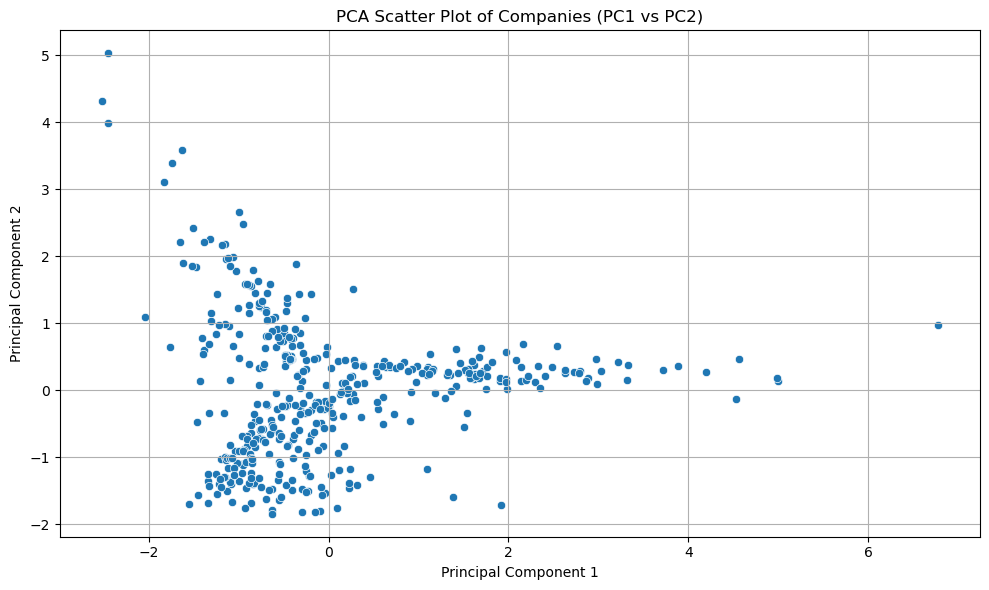

c:\Users\Vasan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
import numpy as np

# Add PCA components to the cleaned DataFrame for visualization and clustering
pca_df_full = pivot_df_clean.copy()
pca_df_full['PC1'] = pca_df['PC1'].values
pca_df_full['PC2'] = pca_df['PC2'].values

# Step 1: Scatter Plot of PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_full, x='PC1', y='PC2')
plt.title('PCA Scatter Plot of Companies (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: MiniBatchKMeans Clustering (e.g., 3 clusters)
X = pca_df[['PC1', 'PC2']].to_numpy()
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)
pca_df_full['Cluster'] = kmeans.fit_predict(X)

# Step 3: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_full, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Company Clusters Based on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Rank companies by PC1 (higher = better ESG performance as a proxy)
pca_df_full['PC1_Rank'] = pca_df_full['PC1'].rank(ascending=False)

# Step 5: View or Save the Ranked Result
pca_ranking = pca_df_full[['PC1', 'PC2', 'Cluster', 'PC1_Rank']].sort_values(by='PC1_Rank')
print(pca_ranking.head())  # View top 5
# Optional: Export to CSV
# pca_ranking.to_csv("pca_ranking_results.csv")


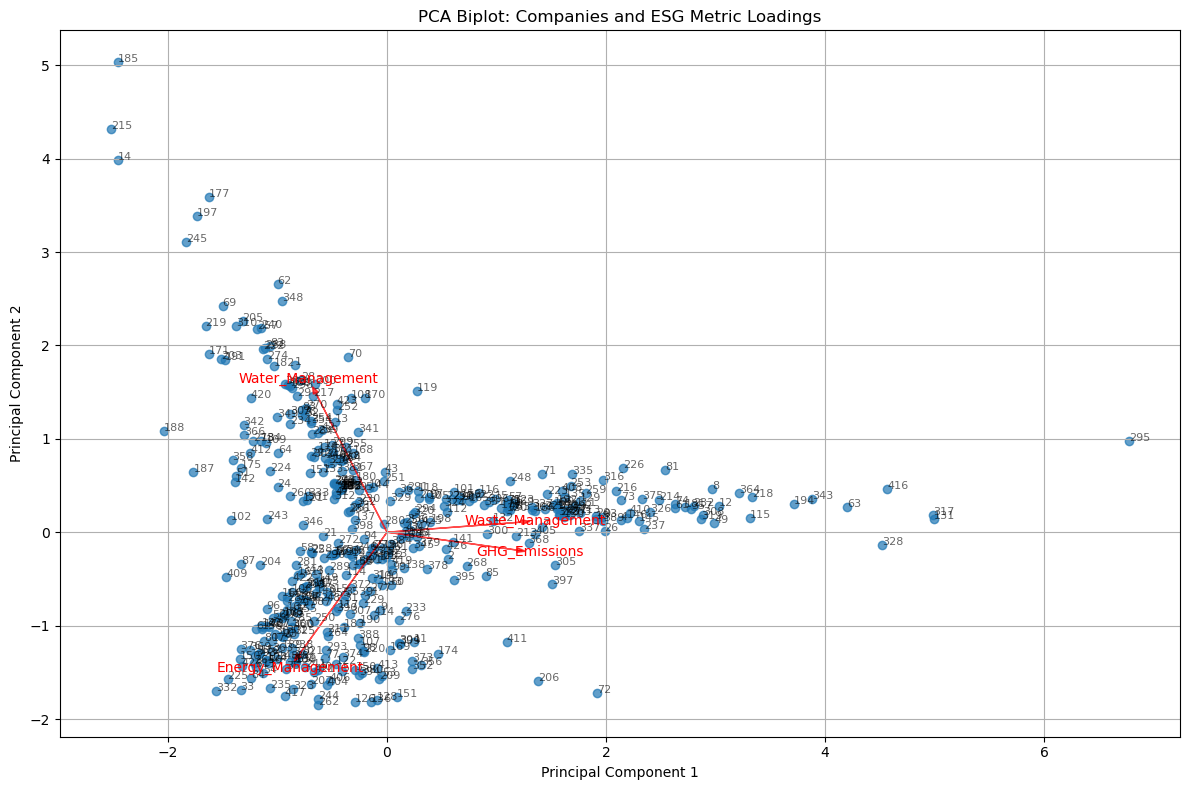

In [ ]:
import matplotlib.pyplot as plt

# Create the biplot for PC1 and PC2
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of companies
ax.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
for i, company in enumerate(pca_df.index):
    ax.text(pca_df['PC1'][i], pca_df['PC2'][i], company, fontsize=8, alpha=0.6)

# Plot arrows for loadings
for feature in loadings_df.index:
    ax.arrow(0, 0,
             loadings_df.loc[feature, 'PC1'] * 2,  # scaled for visibility
             loadings_df.loc[feature, 'PC2'] * 2,
             color='r', alpha=0.7, head_width=0.05)
    ax.text(loadings_df.loc[feature, 'PC1'] * 2.2,
            loadings_df.loc[feature, 'PC2'] * 2.2,
            feature, color='r', ha='center', va='center')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Biplot: Companies and ESG Metric Loadings')
ax.grid(True)
plt.tight_layout()
plt.show()


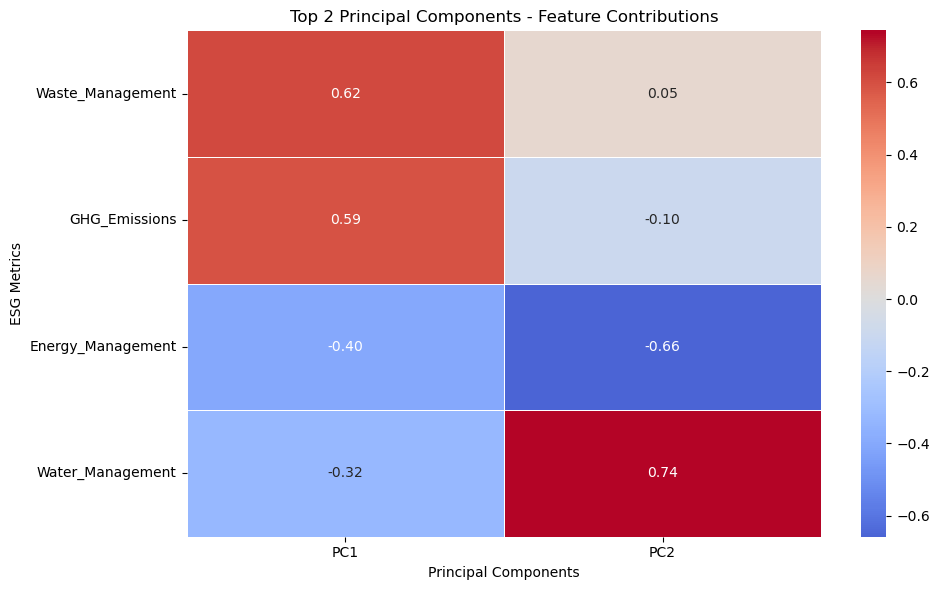

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Select top features across both PCs
top_features = pd.concat([
    loadings_df['PC1'].abs().sort_values(ascending=False).head(6),
    loadings_df['PC2'].abs().sort_values(ascending=False).head(6)
]).index.unique()

# Filter only those features
heatmap_data = loadings_df.loc[top_features, ['PC1', 'PC2']]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title("Top 2 Principal Components - Feature Contributions")
plt.xlabel("Principal Components")
plt.ylabel("ESG Metrics")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the CSV file
file_path = r"C:\Users\Vasan\Downloads\biopharma_sasb_final.csv"
df = pd.read_csv(file_path)

# Show first few rows to understand structure
df.head()


,company_name,perm_id,data_type,disclosure,metric_description,category,metric_unit,metric_value,nb_points_of_observations,pillar,Industry,year,metric_name,data_type_class,model
0,PharmaSGP Holding SE,5074558504,float,ESTIMATED,Total energy consumed by a company within its ...,ENERGYUSETOTAL,GJ,12588.46,158,E_opportunity,Biotechnology & Pharmaceuticals,2017,Energy_Management,quantitative,Energy_Efficiency_Model
1,PharmaSGP Holding SE,5074558504,int,REPORTED,Does the company have a policy to improve its ...,POLICY_WATER_EFFICIENCY,Yes/No,0.00,158,E_opportunity,Biotechnology & Pharmaceuticals,2022,Water_Management,qualitative,Water_Usage_Model
2,PharmaSGP Holding SE,5074558504,int,CALCULATED,Does the company have a policy to improve its ...,POLICY_WATER_EFFICIENCY,Yes/No,0.00,158,E_opportunity,Biotechnology & Pharmaceuticals,2021,Water_Management,qualitative,Water_Usage_Model
3,PharmaSGP Holding SE,5074558504,int,CALCULATED,Does the company have a policy to improve its ...,POLICY_WATER_EFFICIENCY,Yes/No,0.00,158,E_opportunity,Biotechnology & Pharmaceuticals,2020,Water_Management,qualitative,Water_Usage_Model
4,PharmaSGP Holding SE,5074558504,float,ESTIMATED,Total energy consumed by a company within its ...,ENERGYUSETOTAL,GJ,21041.15,158,E_opportunity,Biotechnology & Pharmaceuticals,2021,Energy_Management,quantitative,Energy_Efficiency_Model


In [ ]:
# Step 1: Filter only quantitative metrics with numeric values
quant_df = df[df['data_type_class'] == 'quantitative']

# Step 2: Pivot to get companies as rows and metrics as columns
pivot_df = quant_df.pivot_table(index='company_name', 
                                 columns='metric_name', 
                                 values='metric_value', 
                                 aggfunc='mean')

# Drop rows with missing values for PCA
pivot_df_clean = pivot_df.dropna()

# Step 3: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df_clean)

# Step 4: Apply PCA
pca = PCA(n_components=2)  # reduce to 2 components for visualization
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA result
pca_df = pd.DataFrame(data=pca_components, 
                      columns=['PC1', 'PC2'],
                      index=pivot_df_clean.index)

# Since `ace_tools` is unavailable in this environment, we'll just return the DataFrame directly
pca_df.reset_index(inplace=True)
pca_df.head()


,company_name,PC1,PC2
0,1933 Industries Inc,0.358409,-1.644001
1,1nkemia IUCT Group SA,-0.492948,0.562562
2,2Invest AG,-0.568482,0.645391
3,2Seventy Bio Inc,0.609317,-0.514699
4,3-D Matrix Ltd,-1.142945,-0.186700


In [ ]:
# Step 6: Compute PCA loadings (contributions of original metrics to PCs)

# Get the column names (original ESG metrics)
feature_names = pivot_df_clean.columns

# Create a DataFrame for the PCA loadings
loadings_df = pd.DataFrame(pca.components_.T,
                           columns=['PC1', 'PC2'],
                           index=feature_names)

# Sort by absolute value to show most influential features
loadings_df['PC1_abs'] = loadings_df['PC1'].abs()
loadings_df['PC2_abs'] = loadings_df['PC2'].abs()

# Show top 10 contributing features for each component
top_pc1 = loadings_df.sort_values(by='PC1_abs', ascending=False)[['PC1']].head(10)
top_pc2 = loadings_df.sort_values(by='PC2_abs', ascending=False)[['PC2']].head(10)

top_pc1, top_pc2


(                        PC1
 metric_name                
 GHG_Emissions      0.671457
 Waste_Management   0.609846
 Water_Management  -0.356063
 Energy_Management  0.224617,
                         PC2
 metric_name                
 Energy_Management -0.891972
 Water_Management  -0.334948
 Waste_Management   0.274910
 GHG_Emissions     -0.128919)

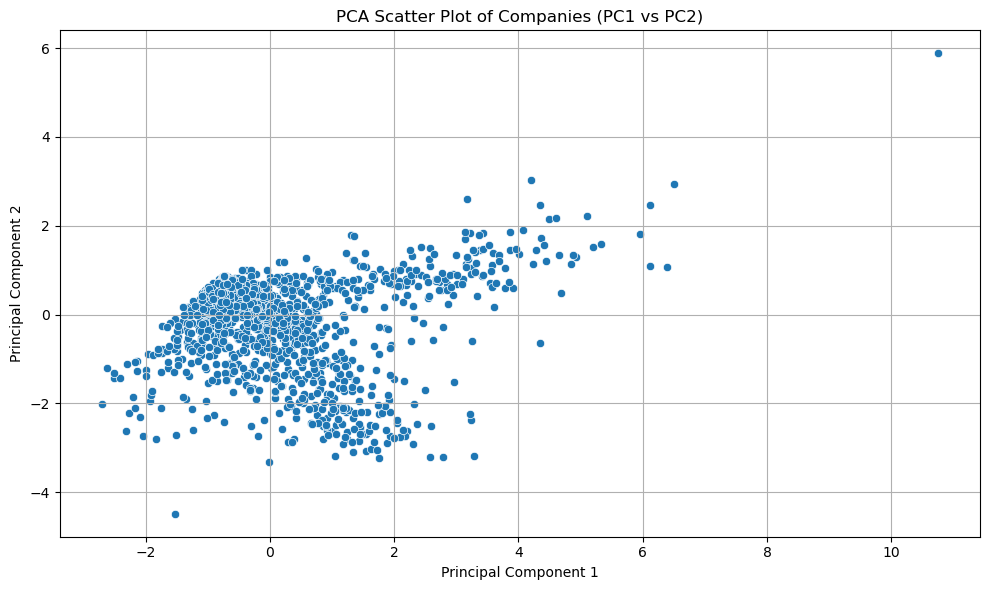

c:\Users\Vasan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
import numpy as np

# Add PCA components to the cleaned DataFrame for visualization and clustering
pca_df_full = pivot_df_clean.copy()
pca_df_full['PC1'] = pca_df['PC1'].values
pca_df_full['PC2'] = pca_df['PC2'].values

# Step 1: Scatter Plot of PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_full, x='PC1', y='PC2')
plt.title('PCA Scatter Plot of Companies (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: MiniBatchKMeans Clustering (e.g., 3 clusters)
X = pca_df[['PC1', 'PC2']].to_numpy()
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)
pca_df_full['Cluster'] = kmeans.fit_predict(X)

# Step 3: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_full, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Company Clusters Based on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Rank companies by PC1 (higher = better ESG performance as a proxy)
pca_df_full['PC1_Rank'] = pca_df_full['PC1'].rank(ascending=False)

# Step 5: View or Save the Ranked Result
pca_ranking = pca_df_full[['PC1', 'PC2', 'Cluster', 'PC1_Rank']].sort_values(by='PC1_Rank')
print(pca_ranking.head())  # View top 5
# Optional: Export to CSV
# pca_ranking.to_csv("pca_ranking_results.csv")

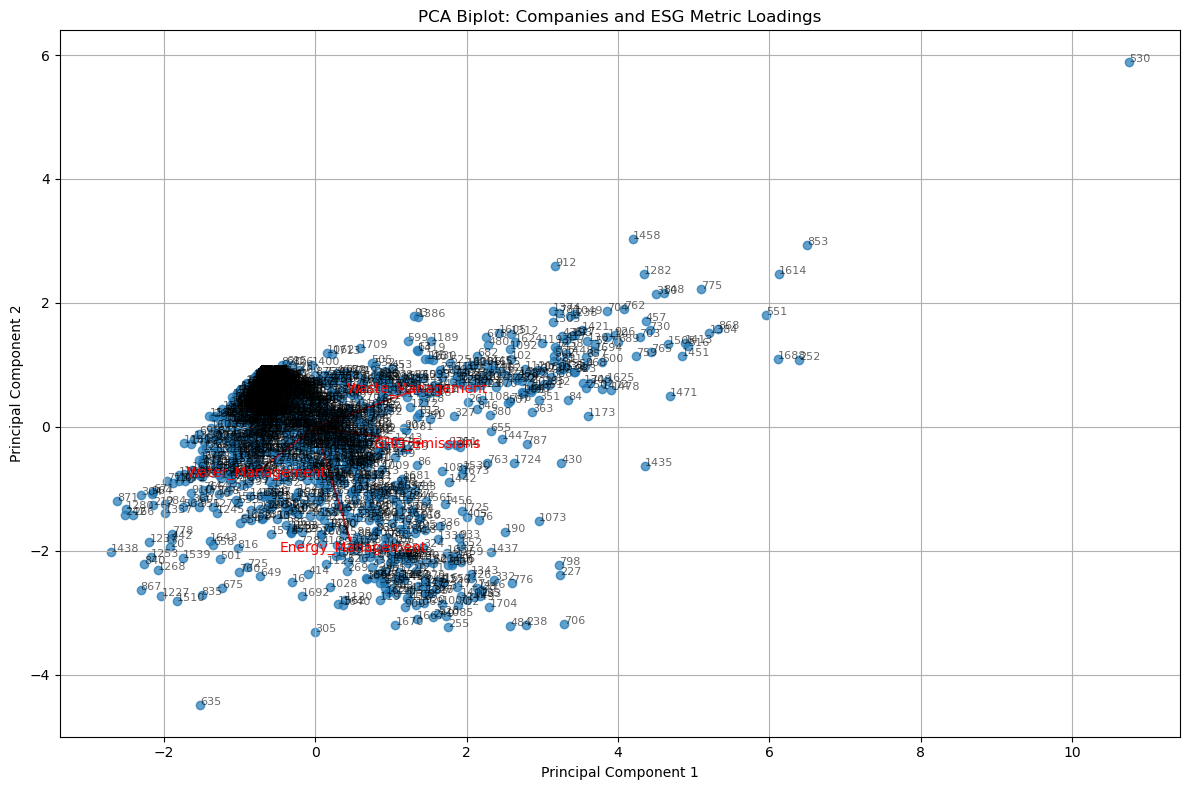

In [ ]:
import matplotlib.pyplot as plt

# Create the biplot for PC1 and PC2
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of companies
ax.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
for i, company in enumerate(pca_df.index):
    ax.text(pca_df['PC1'][i], pca_df['PC2'][i], company, fontsize=8, alpha=0.6)

# Plot arrows for loadings
for feature in loadings_df.index:
    ax.arrow(0, 0,
             loadings_df.loc[feature, 'PC1'] * 2,  # scaled for visibility
             loadings_df.loc[feature, 'PC2'] * 2,
             color='r', alpha=0.7, head_width=0.05)
    ax.text(loadings_df.loc[feature, 'PC1'] * 2.2,
            loadings_df.loc[feature, 'PC2'] * 2.2,
            feature, color='r', ha='center', va='center')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Biplot: Companies and ESG Metric Loadings')
ax.grid(True)
plt.tight_layout()
plt.show()


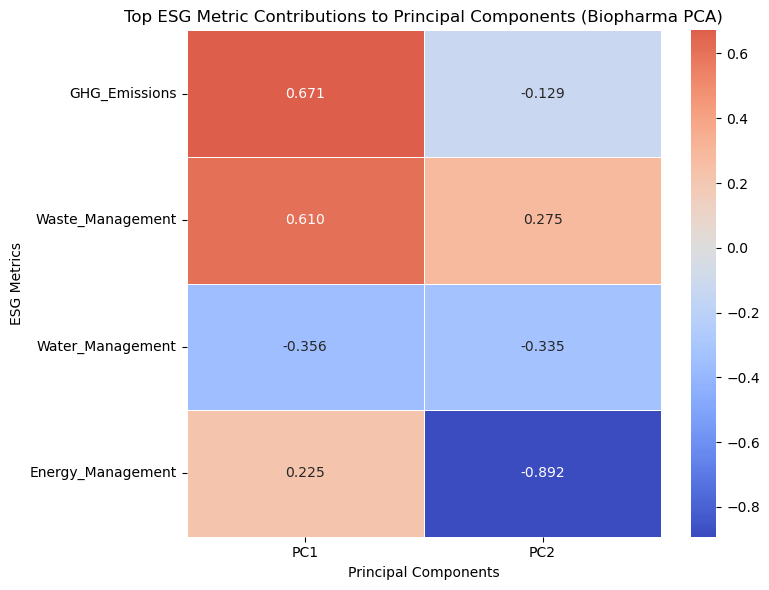

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 4 features from PC1 and PC2 based on absolute values
top_features = pd.concat([
    loadings_df['PC1_abs'].sort_values(ascending=False).head(4),
    loadings_df['PC2_abs'].sort_values(ascending=False).head(4)
]).index.unique()  # avoid duplicates

# Filter the top features for heatmap
heatmap_data = loadings_df.loc[top_features, ['PC1', 'PC2']]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Top ESG Metric Contributions to Principal Components (Biopharma PCA)")
plt.xlabel("Principal Components")
plt.ylabel("ESG Metrics")
plt.tight_layout()
plt.show()
